In [37]:
using SparseArrays
using Arpack
using LinearAlgebra
using Plots
using LaTeXStrings

In [38]:
# This generates a line of points in K-space
function gen_list(xlim, ylim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end
# This generates a mesh-grid of points in K-space
function gen_grid(xlim, ylim, n)
    step = range(0, xlim, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[i, :, :] = gen_list(xlim, ylim, n, 0.5*step[i], (sqrt(3)/2)*step[i])
    end
    grid = reshape(grid, (n * n, 2))
    return grid
end

gen_grid (generic function with 1 method)

The above functions create a parallelogram of points in k-space. This would be useful if we wanted to plot something like the Berry curvature across some number of unit cells. We don't use this function yet, but we might use it later.

In [39]:
# Set the system parameters
a = 2.46
uD = 1
t0 = 3.1
t1 = 0.38
t2 = -0.21
t3 = 0.29
t4 = 0.141
Nl = 4
# pd is point-density
pd = 30
# nvals is number of eigenvalues
nvals = 2 * Nl
xlim = 4*pi/(3*a)
ylim = 2*pi*sqrt(3)/(3*a)
samps = 1000
k_range = range(-2*pi/a, 2*pi/a, samps)
# These vectors will be useful for computing energies at high-symmetry (K and K') points
G1 = [2*pi/a; -2*pi/(sqrt(3) * a)]
G2 = [0; 2*pi/a * 2/sqrt(3)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 0.8513801229240632
 1.4746336294587135

The above parameters are the ones to be used when computing the energies of the Hamiltonian. 
- $a$ is the lattice constant.
- $u_D$ is the potential difference per layer
- $t_0$ is the graphene hopping
- $t_1$ is the vertical interlayer hopping
- $t_2, t_3, t_4$ are higher order (next-nearest, next-next-nearest, ...) hopping
- $N_l$ is the number of layers

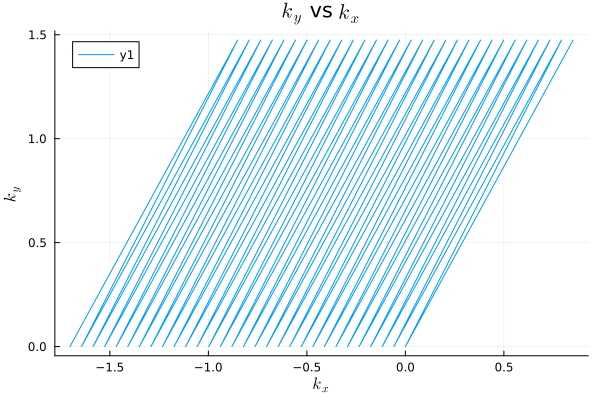

In [40]:
# Example of mesh-grid of pd = 80
k_mesh = gen_grid(xlim, ylim, pd)
plot(k_mesh[:, 1], k_mesh[:, 2], title = L"$k_y$ vs $k_x$", xlabel = L"$k_x$", ylabel = L"$k_y$")

In [41]:
# 2D CCW rotation of v by theta
function rot(theta, v)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R * v
end

rot (generic function with 1 method)

In [42]:
function f(k, a)
    s = 0
    # these rotated delta vectors are the nearest-neighbor vectors
    vec = [0; a/sqrt(3)]
    for n in 0:2
        delta = rot(n * 2*pi / 3, vec)
        s += exp(dot(k, delta)im)
    end
    return s
end

f (generic function with 1 method)

The above functions simply serve to calculate the in-layer graphene hopping contributions.

In [43]:
function uAB(uD, Nl, l)
    return uD * (l + 1 - (1/2) * (Nl - 1))
end

uAB (generic function with 1 method)

Above is the on-site potential as a function of layer-index ($l$). 

In [44]:
function h0(uD, Nl, l, t0, a, k)
    uA = uAB(uD, Nl, l)
    uB = uAB(uD, Nl, l)
    h0 = zeros(ComplexF64, 2, 2)
    h0[1, 1] = uA
    h0[2, 2] = uB
    h0[1, 2] = -t0 * f(k, a)
    h0[2, 1] = -t0 * conj(f(k, a))
    return h0
end

h0 (generic function with 1 method)

The above function calculates the matrix $h_0$ in sublattice space.

In [45]:
function h1(t1, t3, t4, a, k)
    h1 = zeros(ComplexF64, 2, 2)
    h1[1, 1] = t4 * f(k, a)
    h1[1, 2] = t3 * conj(f(k, a))
    h1[2, 1] = t1
    h1[2, 2] = t4 * f(k, a)
    return h1
end

h1 (generic function with 1 method)

The above function calculates the matrix $h_1$ in sublattice space.

In [46]:
function h2(t2)
    h2 = zeros(ComplexF64, 2, 2)
    h2[1,2] = t2/2
    return h2
end

h2 (generic function with 1 method)

The above function calculates the matrix $h_2$ in sublattice space.

In [47]:
function hRG(a, uD, t0, t1, t2, t3, t4, Nl, k)
    # calculate the portion of hRG that has h0 on the diagonal
    ham0 = zeros(2 * Nl, 2 * Nl)
    for l in 1:Nl
        temp = zeros(Nl, Nl)
        temp[l, l] = 1
        ham0 += kron(h0(uD, Nl, l, t0, a, k), temp)
    end
    # calculate the portion of hRG that has h1 1 above and below the diagonal
    utri1 = zeros(Nl, Nl)
    for i in 2:Nl
        utri1[i - 1, i] = 1
    end
    ham1 = kron(h1(t1, t3, t4, a, k), utri1) + adjoint(kron(h1(t1, t3, t4, a, k), utri1))
    # calculate the portion of hRG that h2 2 above and below the diagonal
    utri2 = zeros(Nl, Nl)
    for i in 3:Nl
        utri2[i - 2, i] = 1
    end
    ham2 = kron(h2(t2), utri2) + adjoint(kron(h2(t2), utri2))
    # get all the contributions of hRG from the various matrices in sublattice space
    return ham0 + ham1 + ham2
end

hRG (generic function with 1 method)

In [48]:
# Want to get dispersions aroung K point
K_eigenvals = Array{Float64}(undef, samps, nvals)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx; ky])
    vals = eigvals(ham)
    for p in 1:nvals
        K_eigenvals[i, p] = real(vals[p])
    end
end
# Want to get dispersions aroung K' point
Kp_eigenvals = Array{Float64}(undef, samps, nvals)
for i in 1:samps
    kx = k_range[i]
    ky = Kp[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx; ky])
    vals = eigvals(ham)
    for p in 1:nvals
        Kp_eigenvals[i, p] = real(vals[p])
    end
end

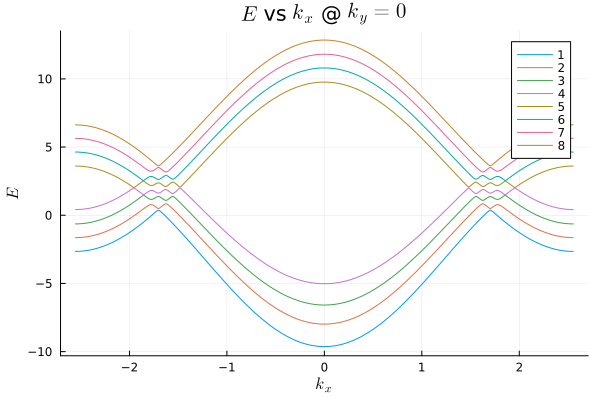

In [49]:
P = plot()
plot!(P, title = L"$E$ vs $k_x$ @ $k_y = 0$", xlabel = L"$k_x$", ylabel = L"$E$")
for i in 1:nvals
    plot!(k_range, K_eigenvals[:, i], label = string(i))
end
display(P)

Note that the gap closes at the $K$ points of the Brillouin Zone.

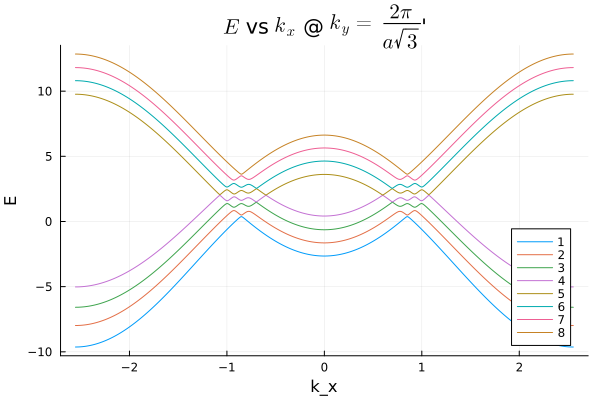

In [50]:
P = plot()
plot!(P, title = L"$E$ vs $k_x$ @ $k_y = \frac{2 \pi}{a \sqrt{3}}$'", xlabel = "k_x", ylabel = "E")
for i in 1:nvals
    plot!(k_range, Kp_eigenvals[:, i], label = string(i))
end
display(P)

Note that the gap closes at the $K^\prime$ points of the Brillouin Zone.